# Dog Vs Cat: Model Prediction Test

## Enviroment Setup

In [1]:
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import numpy as np
import os
import glob
import cv2
from collections import Counter
import random


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 5.0)


Using TensorFlow backend.


## Global Variables Initialazation

In [2]:
LABEL_LIST = sorted(["dog", "cat"])
TEST_IMAGE_PATH_LIST = ["./test_image"]
MODEL_PATH = "./models"

## Helper Functions

In [3]:
def label_one_hot_encoding(labe_list):
    encoder = LabelEncoder()
    transfomed_label = encoder.fit_transform(labe_list)
    one_hot_encoded_labels =  np_utils.to_categorical(transfomed_label)
    one_hot_label_dict = {}
    for i  in range(len(labe_list)):
        one_hot_label_dict[labe_list[i]] = one_hot_encoded_labels[i] 
    
    return one_hot_label_dict


def load_samples(DATA_PATH, one_hot_encoding_dict):
    labels = one_hot_encoding_dict.keys()    
    samples = [] # [one_hot_label, image_path]
    temp_size = 0
    for dir in DATA_PATH: 
        print("loading data from: " + dir)
        for key in labels:           
            samples += [[one_hot_encoding_dict[key],file] for file in glob.glob(os.path.join(dir, key + '*.jpg'))]
            temp_size = len(samples) - temp_size    
            print("total " + str(temp_size) + " " + key + " images loaded.")
            temp_size = len(samples)
        
        print("total " + str(temp_size) + " raw data samples loaded.")
        
    return samples


def resize_image(image, output_shape = (100, 100)):
    """
    resize image to proper shape, the color channel will not be touched
    """      
    shape = (output_shape[0], output_shape[1])    
    resized_image = cv2.resize(image, shape)
    return resized_image



model_path_list = sorted(glob.glob(os.path.join(MODEL_PATH + '/*.h5')))
print("models: ", model_path_list)


one_hot_encoding_dict = label_one_hot_encoding(LABEL_LIST)
print("label encoding is done.", one_hot_encoding_dict)
    
raw_samples = load_samples(TEST_IMAGE_PATH_LIST, one_hot_encoding_dict)
print("raw sample loaded.")


models:  ['./models/ResNet.h5', './models/VGG16.h5', './models/VGG19.h5', './models/hombrew_model.h5']
label encoding is done. {'cat': array([ 1.,  0.]), 'dog': array([ 0.,  1.])}
loading data from: ./test_image
total 5 cat images loaded.
total 6 dog images loaded.
total 11 raw data samples loaded.
raw sample loaded.


## Model Prediction Functions

In [4]:
def predict(model, image, one_hot_encoding_dict):
    inv_encoding = {tuple(map(int, v)): k for k, v in one_hot_encoding_dict.items()}
    
    image_input_shape = (model.input_shape[1], model.input_shape[2])
    
    #print(image_input_shape, (image.shape[0], image.shape[1]))
    
    if (image.shape[0], image.shape[1]) != image_input_shape:
        image = resize_image(image, image_input_shape)
   
    
    image = np.expand_dims(image, axis=0)
    
    raw_prediction = model.predict(image)
    raw_prediction = np.squeeze(raw_prediction)
    
    normalized_prediction = tuple([1 if max(raw_prediction) == i else 0 for i in raw_prediction])

    
    return raw_prediction , inv_encoding[normalized_prediction]


def predict_and_plot(image_path_list, model_dict, one_hot_encoding_dict):
    
    for image_path in image_path_list:
        image = cv2.imread(image_path)
        image_name = image_path.split("/")[-1].split("\\")[-1]
        prediction_text = image_name + "\n"
        for model_name in sorted(model_dict.keys()):
            model = load_model(model_dict[model_name])
            raw_prediction, label = predict(model, image, one_hot_encoding_dict)
            prediction_text += model_name + " predction: " + label + " raw output: " + str(raw_prediction) + "\n"
            #print(prediction_text)
        
        plt.title(prediction_text)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.savefig("./resource/" + image_name + "_prediction.jpg", bbox_inches="tight")
        plt.show()

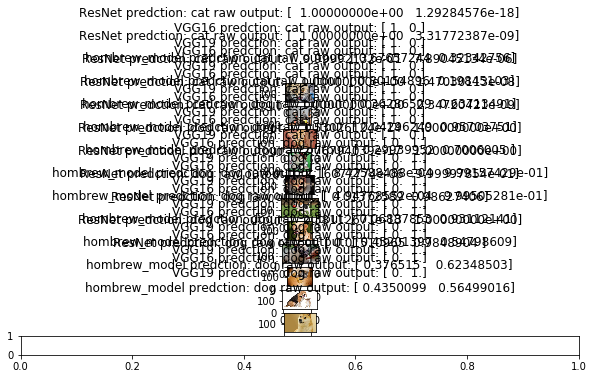

In [5]:
test_image_path = sorted(glob.glob(os.path.join("./test_image" + '/*.jpg')))

model_dict = dict([(path.split("/")[-1].split("\\")[-1].split(".")[0], path)  for path in model_path_list])
predict_and_plot(test_image_path, model_dict, one_hot_encoding_dict)